<a href="https://colab.research.google.com/github/osanseviero/diffuse-it/blob/main/Diffuse_It.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffuse It! 🤗🖼️

Train a Diffusion model with images of a term you define in just a couple of minutes and have a demo for anyone to try out!

To use this tool, you don't need to know programming or the underlying tools. Click ▶ of each cell of code!

In [ ]:
%%capture
! pip install git+https://github.com/osanseviero/diffusers.git
! pip install modelcards accelerate datasets gradio
! sudo apt -qq install git-lfs
! git config --global credential.helper store

In [ ]:
import requests
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from torch.utils.data import DataLoader

# Setup and Defining your search term

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


Simply replace the terms in the widget below with whatever you want to generate, and we'll download ~150 images for the term. **Note that if you want to upload your own images, you can skip this section.** 

Please use a single word

In [ ]:
term = "aurora" #@param {type:"string"}

search_terms = sorted([
    term,
])

search_terms = [x for x in search_terms if x.strip() != '']

Here, we loop over your selected search term and collect ~150 related images.

We'll save them to a new folder named `images/` that is structured to work with `load_dataset` from the 🤗`datasets` library, which allows loading a directory of images into a `Dataset` object. 



## Download Images from the web

In [ ]:
SEARCH_URL = "https://huggingface.co/api/experimental/images/search"

def get_image_urls_by_term(search_term: str, count=150):
    params  = {"q": search_term, "license": "public", "imageType": "photo", "count": count}
    response = requests.get(SEARCH_URL, params=params)
    response.raise_for_status()
    response_data = response.json()
    image_urls = [img['thumbnailUrl'] for img in response_data['value']]
    return image_urls


def gen_images_from_urls(urls):
    num_skipped = 0
    for url in urls:
        response = requests.get(url)
        if not response.status_code == 200:
            num_skipped += 1
        try:
            img = Image.open(BytesIO(response.content))
            yield img
        except UnidentifiedImageError:
            num_skipped +=1

    print(f"Retrieved {len(urls) - num_skipped} images. Skipped {num_skipped}.")


def urls_to_image_folder(urls, save_directory):
    for i, image in enumerate(gen_images_from_urls(urls)):
        image.save(save_directory / f'{i}.jpg')

data_dir = Path('images')

if data_dir.exists():
    shutil.rmtree(data_dir)

for search_term in search_terms:
    search_term_dir = data_dir / search_term
    search_term_dir.mkdir(exist_ok=True, parents=True)
    urls = get_image_urls_by_term(search_term)
    print(f"Saving images of {search_term} to {str(search_term_dir)}...")
    urls_to_image_folder(urls, search_term_dir)

Saving images of aurora to images/aurora...
Retrieved 149 images. Skipped 0.


Note: if you want to use your own images instead of the ones downloaded from the web, this is the moment to upload them to the directory images/name. name can be any short name that describes the images (e.g. llamas).


In [ ]:
from datasets import load_dataset
dataset = load_dataset(f"images/{term}")["train"]

Resolving data files:   0%|          | 0/149 [00:00<?, ?it/s]

Using custom data configuration aurora-5bdb831a3c5c218e


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/aurora-5bdb831a3c5c218e/0.0.0/48efdc62d40223daee675ca093d163bcb6cb0b7d7f93eb25aebf5edca72dc597. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 149
})

## Let's look at results

#### ⚠️ Note - The image search API isn't perfect ⚠️

You may need to go back, tweak your search terms, and repeat the cells above until the images shown below look good.

A few bad images is OK, but if they are completely incorrect, you'll definitely want to try again with different terms.

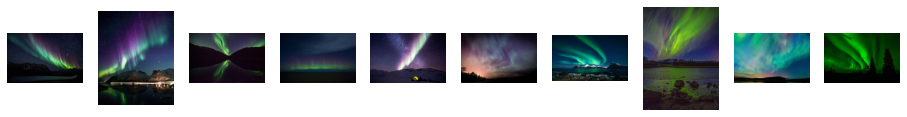

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 10, figsize=(16, 4))
for i, image in enumerate(dataset[:10]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

## Preparation for training

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 32  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = f"my-{term}"  # the model namy locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0
    dataset = term

config = TrainingConfig()

In [ ]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [ ]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

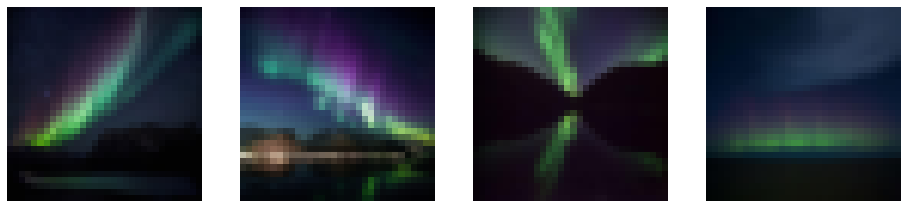

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

In [ ]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [ ]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, tensor_format="pt")

In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

## Training setup

In [ ]:
from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size, 
        generator=torch.manual_seed(config.seed),
    )["sample"]

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [ ]:
from accelerate import Accelerator
from diffusers.hub_utils import init_git_repo, push_to_hub

from tqdm.auto import tqdm
import torch.nn.functional as F
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo = init_git_repo(config, at_init=True)
        accelerator.init_trackers("train_example")
    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps)["sample"]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
    push_to_hub(config, pipeline, repo, commit_message=f"Epoch {epoch}", blocking=True)

## Train! 🚆 (5-30 minutes, so good time to get some 🍿

In [ ]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


Cloning https://huggingface.co/osanseviero/my-aurora into local empty directory.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Upload file unet/diffusion_pytorch_model.bin:   0%|          | 3.34k/434M [00:00<?, ?B/s]

Upload file logs/train_example/events.out.tfevents.1658678152.1ff9700cd9f5.71.0:   5%|5         | 3.34k/61.7k …

To https://huggingface.co/osanseviero/my-aurora
   b5bc08a..7a03273  main -> main

To https://huggingface.co/osanseviero/my-aurora
   7a03273..6c5f430  main -> main



## Create online demo (takes 2-3 minutes to build)

In [ ]:
from huggingface_hub import whoami, create_repo, upload_file

namespace = whoami()["name"]
name = f"my-{term}"
repo_id = f"{namespace}/{name}"

create_repo(repo_id, repo_type="space", space_sdk="gradio", exist_ok=True)

'https://huggingface.co/spaces/osanseviero/my-aurora'

In [ ]:
demo_code = f"""from diffusers import DDPMPipeline
import torch
import PIL.Image
import gradio as gr
import random
import numpy as np

ddpm_pipeline = DDPMPipeline.from_pretrained("{repo_id}")

def predict(seed=42):
    generator = torch.manual_seed(seed)
    images = ddpm_pipeline(generator=generator)["sample"]
    return images[0]

random_seed = random.randint(0, 2147483647)
gr.Interface(
    predict,
    inputs=[
        gr.inputs.Slider(0, 2147483647, label='Seed', default=random_seed, step=1),
    ],
    outputs=gr.Image(shape=[32,32], type="pil", elem_id="output_image"),
    title="Generate {term} with diffusers!",
    description="This demo the <a href=\\"https://huggingface.co/{repo_id}\\">{name}</a> model to generate {term} created by <a href=\\"https://huggingface.co/{namespace}\\">{namespace}</a> using the <a href=\\"https://github.com/osanseviero/diffuse-it\\">Diffuse It! tool</a>. Inference might take around a minute.",
).launch(debug=True, enable_queue=True)
"""

In [ ]:
with open("app.py", "w") as demo_file:
  demo_file.write(demo_code)

upload_file(
    path_or_fileobj="app.py",
    path_in_repo="app.py",
    repo_id=repo_id,
    repo_type="space"
)

'https://huggingface.co/spaces/osanseviero/my-aurora/blob/main/app.py'

In [ ]:
with open("requirements.txt", "w") as req_file:
  req_file.write("diffusers==0.1.1")

upload_file(
    path_or_fileobj="requirements.txt",
    path_in_repo="requirements.txt",
    repo_id=repo_id,
    repo_type="space"
)

'https://huggingface.co/spaces/osanseviero/my-aurora/blob/main/requirements.txt'

In [ ]:
from modelcards import ModelCard

card = ModelCard.load(repo_id)
card.data.tags.append("diffuse-it")
card.push_to_hub(repo_id)

## Congrats! 🥳

Congrats! You just trained your first diffuser model, shared it with the community and create a demo for it!

In [ ]:
print(f"Find the model repository at https://huggingface.co/{repo_id}")

Find the model repository at https://huggingface.co/osanseviero/my-aurora


In [ ]:
print(f"Find the demo at https://huggingface.co/spaces/{repo_id} and share it with the community")

Find the demo at https://huggingface.co/spaces/osanseviero/my-aurora and share it with the community


You can even see the embedded gradio demo here!

In [ ]:
import gradio as gr

gr.Interface.load(f"spaces/{repo_id}").launch()

Fetching interface from: https://huggingface.co/spaces/osanseviero/my-aurora
Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://52598.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7f150074dbd0>,
 'http://127.0.0.1:7860/',
 'https://52598.gradio.app')